In [4]:
import hashlib
import os

from collections import defaultdict
from PIL import Image

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

2024-01-11 03:01:30.860926: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# EDA

## Images and categories

In [2]:
total_images = 0
cat_counts = {}

for dirpath, dirnames, filenames in os.walk('data'):
    if len(dirnames) == 0:
        total_images += len(filenames)
        cat_counts[os.path.basename(dirpath)] = len(filenames)

print(f"{total_images=}")
print(f"Total categories: {len(cat_counts.keys())}")
print(f"Images per category: {cat_counts}")

total_images=13711
Total categories: 23
Images per category: {'Seahorse': 478, 'Sea Urchins': 579, 'Clams': 497, 'Turtle_Tortoise': 1903, 'Dolphin': 782, 'Jelly Fish': 845, 'Penguin': 482, 'Squid': 483, 'Crabs': 499, 'Lobster': 499, 'Whale': 572, 'Eel': 497, 'Otter': 500, 'Starfish': 499, 'Seal': 414, 'Puffers': 531, 'Sea Rays': 517, 'Sharks': 590, 'Shrimp': 488, 'Octopus': 562, 'Fish': 494, 'Corals': 500, 'Nudibranchs': 500}


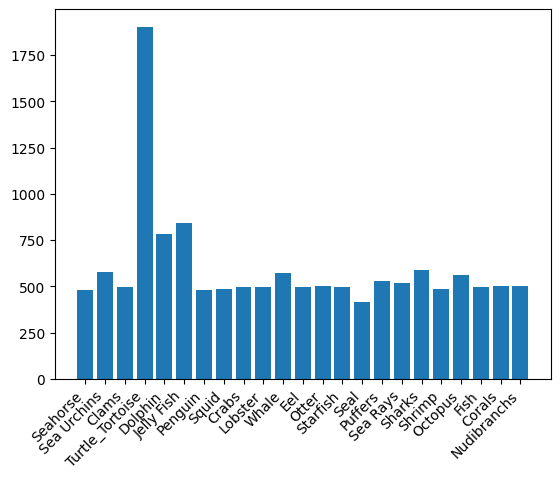

In [3]:
keys = list(cat_counts.keys())
vals = list(cat_counts.values())
plt.bar(range(len(cat_counts)), vals, tick_label=keys)
plt.xticks(rotation=45, ha='right')
plt.show()

## Identify duplicate images

Why do we care whether there are duplicate images? Duplicates can cause issues like making certain images have more of a "weight" in the training, which we don't want. 

In [4]:
seen_files = defaultdict(list)

for dirpath, dirnames, filenames in os.walk('data'):
    for f in filenames:
        filepath = os.path.join(dirpath, f)
        with open(filepath, 'rb') as fp:
            file_digest = hashlib.file_digest(fp, 'md5').hexdigest()
            seen_files[file_digest].append(filepath)

In [5]:
dupes = [files for _, files in seen_files.items() if len(files) > 1]
print(f"There are {len(dupes)} groups of duplicates")
dupes

There are 58 groups of duplicates


[['data/seacreatures/Seahorse/5120704764_1039a3dab2_o.jpg',
  'data/seacreatures/Seahorse/5120625360_5a41f45599_o.jpg'],
 ['data/seacreatures/Sea Urchins/3084448568_c73bd84762_o.jpg',
  'data/seacreatures/Sea Urchins/2515696078_30911f8022_o.jpg'],
 ['data/seacreatures/Sea Urchins/2415324362_7af0d50dff_o.jpg',
  'data/seacreatures/Sea Urchins/2410254965_997a170847_o.jpg'],
 ['data/seacreatures/Sea Urchins/14663143746_ab57259f86_o.jpg',
  'data/seacreatures/Sea Urchins/9268307830_8cca53090c_o.jpg'],
 ['data/seacreatures/Clams/33573217048_49779c6e3a_o.jpg',
  'data/seacreatures/Octopus/33573217048_49779c6e3a_o.jpg'],
 ['data/seacreatures/Clams/35267497856_25562bf235_o.jpg',
  'data/seacreatures/Sea Rays/35267497856_25562bf235_o.jpg'],
 ['data/seacreatures/Clams/23683207094_f22da34528_b.jpg',
  'data/seacreatures/Puffers/23683207094_f22da34528_b.jpg',
  'data/seacreatures/Octopus/23683207094_f22da34528_b.jpg'],
 ['data/seacreatures/Clams/24285332966_0e3d609212_b.jpg',
  'data/seacreatures/

data/seacreatures/Seahorse/5120704764_1039a3dab2_o.jpg
data/seacreatures/Seahorse/5120625360_5a41f45599_o.jpg


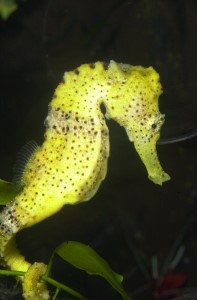



data/seacreatures/Sea Urchins/3084448568_c73bd84762_o.jpg
data/seacreatures/Sea Urchins/2515696078_30911f8022_o.jpg


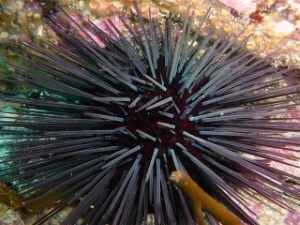



data/seacreatures/Sea Urchins/2415324362_7af0d50dff_o.jpg
data/seacreatures/Sea Urchins/2410254965_997a170847_o.jpg


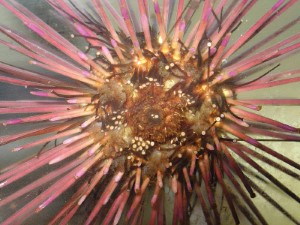



data/seacreatures/Sea Urchins/14663143746_ab57259f86_o.jpg
data/seacreatures/Sea Urchins/9268307830_8cca53090c_o.jpg


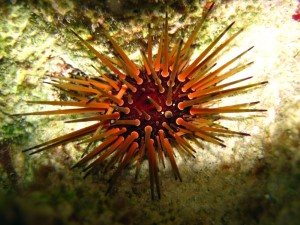



data/seacreatures/Clams/33573217048_49779c6e3a_o.jpg
data/seacreatures/Octopus/33573217048_49779c6e3a_o.jpg


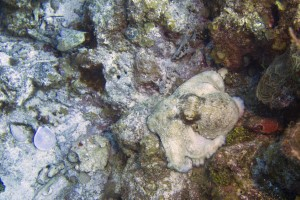



data/seacreatures/Clams/35267497856_25562bf235_o.jpg
data/seacreatures/Sea Rays/35267497856_25562bf235_o.jpg


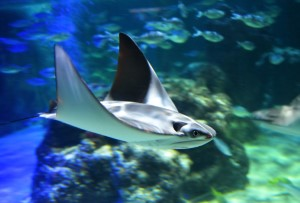



data/seacreatures/Clams/23683207094_f22da34528_b.jpg
data/seacreatures/Puffers/23683207094_f22da34528_b.jpg
data/seacreatures/Octopus/23683207094_f22da34528_b.jpg


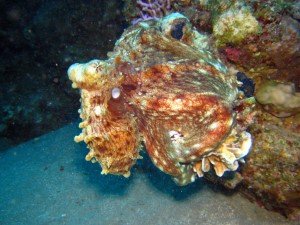



data/seacreatures/Clams/24285332966_0e3d609212_b.jpg
data/seacreatures/Eel/24285332966_0e3d609212_b.jpg
data/seacreatures/Puffers/24285332966_0e3d609212_b.jpg


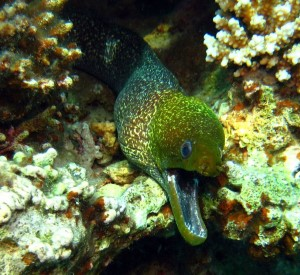



data/seacreatures/Turtle_Tortoise/Turtle_Tortoise (1324).jpg
data/seacreatures/Dolphin/Dolphin (262).jpg


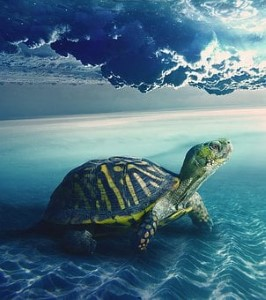



data/seacreatures/Dolphin/Dolphin (116).jpg
data/seacreatures/Whale/Whale (79).jpg


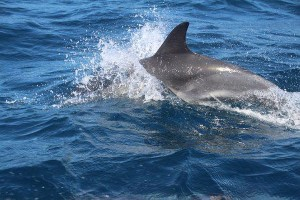



data/seacreatures/Dolphin/5602252750_f74fdce670_b.jpg
data/seacreatures/Whale/5602252750_f74fdce670_b.jpg


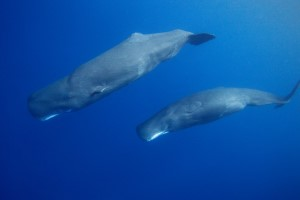



data/seacreatures/Dolphin/5695747132_3b9fb56d21_b.jpg
data/seacreatures/Sharks/5695747132_3b9fb56d21_b.jpg


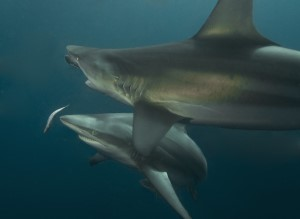



data/seacreatures/Dolphin/Dolphin (265).jpg
data/seacreatures/Whale/Whale (45).jpg


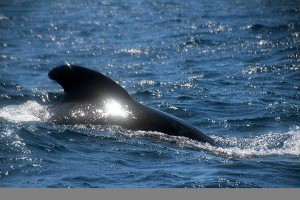



data/seacreatures/Dolphin/5708479535_b439db2902_b.jpg
data/seacreatures/Dolphin/6061363882_1ec0aef4fd_b.jpg


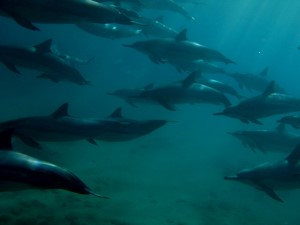



data/seacreatures/Dolphin/Dolphin (253).jpg
data/seacreatures/Sharks/Sharks (78).jpg


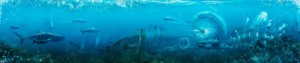



data/seacreatures/Dolphin/5830776993_0086d00dde_b.jpg
data/seacreatures/Dolphin/6091413688_112dace94f_b.jpg


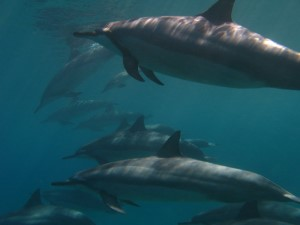



data/seacreatures/Dolphin/Dolphin (219).jpg
data/seacreatures/Whale/Whale (21).jpg


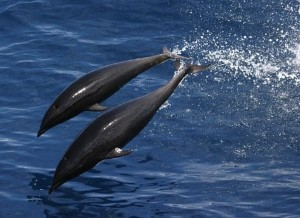



data/seacreatures/Dolphin/Dolphin (274).jpg
data/seacreatures/Whale/Whale (69).jpg


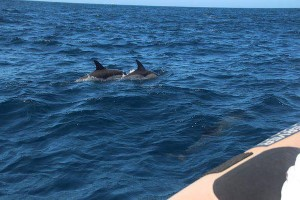



data/seacreatures/Dolphin/7087312705_e184519080_o.jpg
data/seacreatures/Whale/7087312705_e184519080_o.jpg


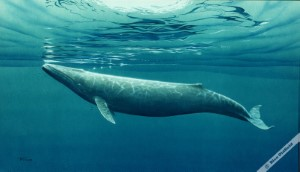



data/seacreatures/Dolphin/Dolphin (275).jpg
data/seacreatures/Whale/Whale (70).jpg


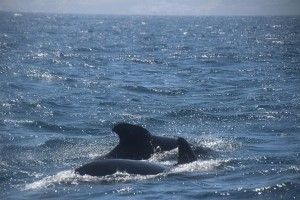



data/seacreatures/Dolphin/Dolphin (166).jpg
data/seacreatures/Whale/Whale (80).jpg


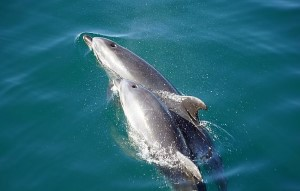



data/seacreatures/Dolphin/3078900773_20e97d02b0_o.jpg
data/seacreatures/Dolphin/5706176079_3c8e1e794a_o.jpg


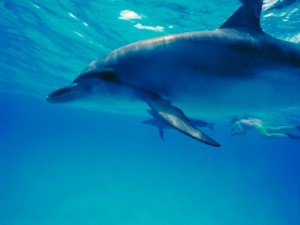



data/seacreatures/Dolphin/5335822460_09826ffb76_o.jpg
data/seacreatures/Dolphin/5290280121_0463b410cf_o.jpg


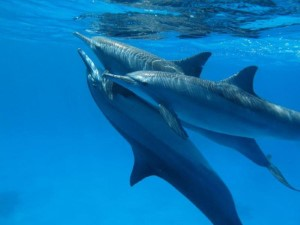



data/seacreatures/Dolphin/9218832535_e23e83e251_o.jpg
data/seacreatures/Sharks/9218832535_e23e83e251_o.jpg


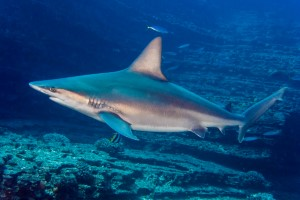



data/seacreatures/Dolphin/Dolphin (266).jpg
data/seacreatures/Whale/Whale (46).jpg


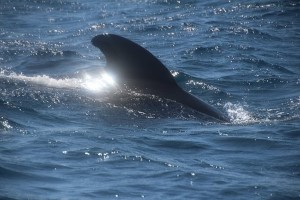



data/seacreatures/Squid/16718089763_7420eabc03_b.jpg
data/seacreatures/Shrimp/16718089763_7420eabc03_b.jpg


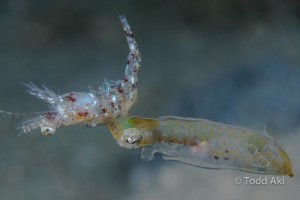



data/seacreatures/Squid/26242466259_eff8db7db3_b.jpg
data/seacreatures/Whale/26242466259_eff8db7db3_b.jpg


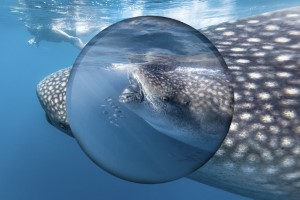



data/seacreatures/Squid/23506605092_dd932ba76f_o.jpg
data/seacreatures/Octopus/23506605092_dd932ba76f_o.jpg


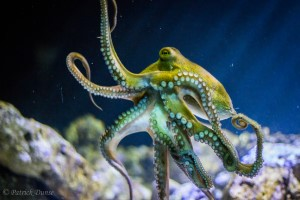



data/seacreatures/Squid/5263732245_646f5c2022_b.jpg
data/seacreatures/Octopus/5263732245_646f5c2022_b.jpg


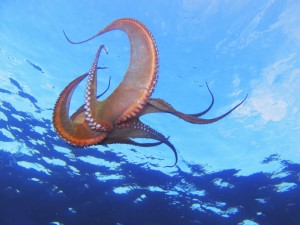



data/seacreatures/Lobster/2756610035_5e8f77a38a_o.jpg
data/seacreatures/Eel/2756610035_5e8f77a38a_o.jpg


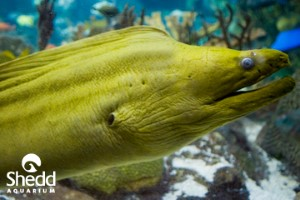



data/seacreatures/Whale/5884633459_a1407bb432_o.jpg
data/seacreatures/Whale/8885991845_cdf46a09c1_o.jpg
data/seacreatures/Whale/14408875945_83bf5b3041_o.jpg
data/seacreatures/Whale/27332450300_2082f7dd1e_o.jpg
data/seacreatures/Whale/12314194215_5f2e4599e1_o.jpg
data/seacreatures/Whale/16337413221_f45977d3fc_o.jpg
data/seacreatures/Whale/15154397421_55ddf1a208_o.jpg
data/seacreatures/Whale/9714826840_c9eef93ed4_o.jpg
data/seacreatures/Whale/13204885803_f98141cd73_o.jpg
data/seacreatures/Whale/22659499422_5102e91f14_o.jpg
data/seacreatures/Whale/21952441864_ab2bca8f29_o.jpg
data/seacreatures/Whale/7156017226_f85c67ed13_o.jpg
data/seacreatures/Whale/12824915644_1c550dd374_o.jpg


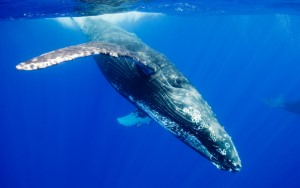



data/seacreatures/Whale/2989055761_b37caa2be0_o.jpg
data/seacreatures/Whale/12275270214_889a1178be_o.jpg
data/seacreatures/Whale/27405671356_b6b78b2026_o.jpg
data/seacreatures/Whale/5187196929_944ef4ac00_o.jpg
data/seacreatures/Whale/14202492937_1e301206f9_o.jpg


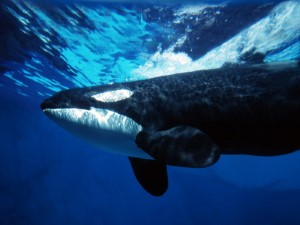



data/seacreatures/Whale/2309635431_b3d0522748_o.jpg
data/seacreatures/Sharks/2309635431_b3d0522748_o.jpg


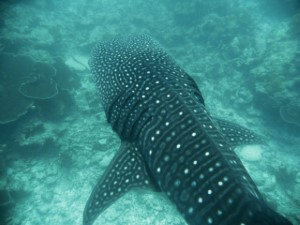



data/seacreatures/Whale/3869466947_c54b7ff964_o.jpg
data/seacreatures/Sharks/3869466947_c54b7ff964_o.jpg


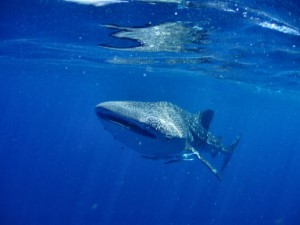



data/seacreatures/Whale/29853353308_2c91520e29_o.jpg
data/seacreatures/Sharks/29853353308_2c91520e29_o.jpg


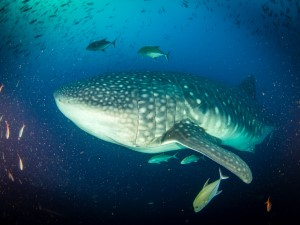



data/seacreatures/Whale/8941836613_0c813aa1a1_b.jpg
data/seacreatures/Sharks/8941836613_0c813aa1a1_b.jpg


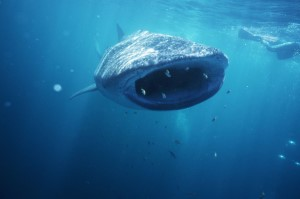



data/seacreatures/Whale/8942450118_f86174cd44_b.jpg
data/seacreatures/Sharks/8942450118_f86174cd44_b.jpg


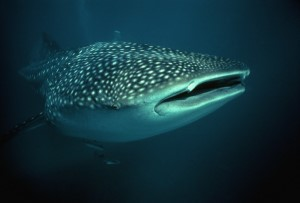



data/seacreatures/Whale/43700648742_98d25195ec_o.jpg
data/seacreatures/Sharks/43700648742_98d25195ec_o.jpg


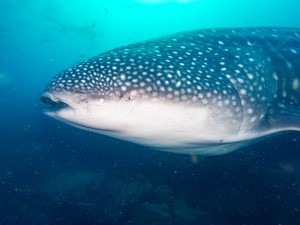



data/seacreatures/Whale/29853334788_14998461c9_o.jpg
data/seacreatures/Sharks/29853334788_14998461c9_o.jpg


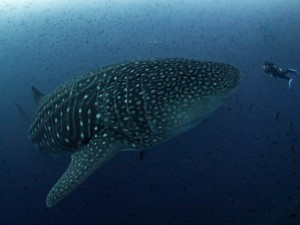



data/seacreatures/Whale/Whale (64).jpg
data/seacreatures/Sharks/Sharks (83).jpg


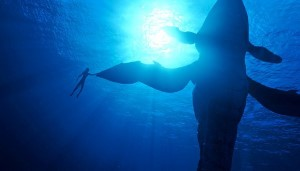



data/seacreatures/Whale/5315747486_d9119cd5e0_o.jpg
data/seacreatures/Whale/869692063_8e3b782205_o.jpg
data/seacreatures/Sharks/869692063_8e3b782205_o.jpg


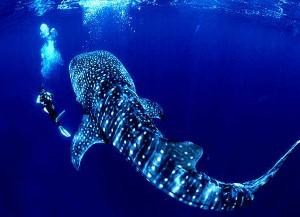



data/seacreatures/Whale/8941813517_09e552e1f7_b.jpg
data/seacreatures/Sharks/8941813517_09e552e1f7_b.jpg


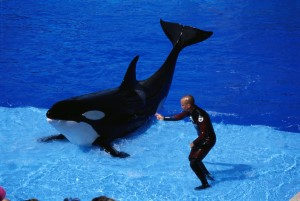



data/seacreatures/Whale/32204840014_0017291d6d_o.jpg
data/seacreatures/Sharks/32204840014_0017291d6d_o.jpg


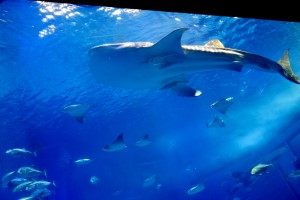



data/seacreatures/Whale/43007890704_59e7f44985_o.jpg
data/seacreatures/Sharks/43007890704_59e7f44985_o.jpg


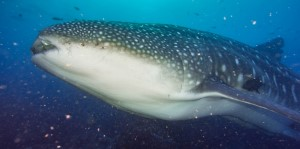



data/seacreatures/Eel/5169235140_5f112dcdff_o.jpg
data/seacreatures/Eel/4849164808_fcec1b3fce_o.jpg


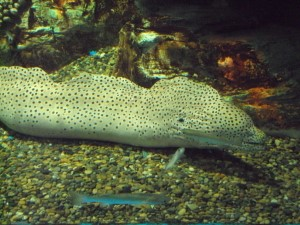



data/seacreatures/Eel/19489662540_85cce016a2_b.jpg
data/seacreatures/Shrimp/19489662540_85cce016a2_b.jpg


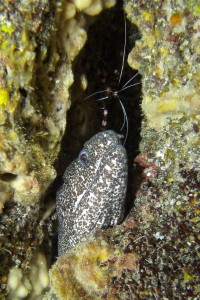



data/seacreatures/Eel/31875240943_137c1138f5_o.jpg
data/seacreatures/Sea Rays/31875240943_137c1138f5_o.jpg


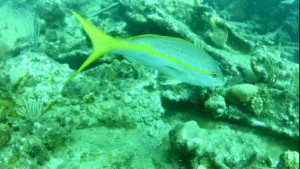



data/seacreatures/Eel/31881686523_8f498d85f4_o.jpg
data/seacreatures/Puffers/31881686523_8f498d85f4_o.jpg


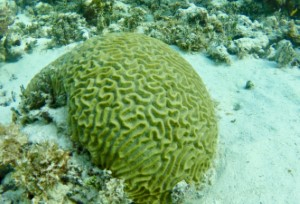



data/seacreatures/Otter/4772002061_f9427f5bfb_o.jpg
data/seacreatures/Otter/3648067832_75017b4c35_o.jpg


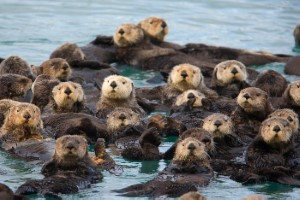



data/seacreatures/Otter/1445716896_d60efca90a_o.jpg
data/seacreatures/Otter/1445749364_6e472c3ec0_o.jpg


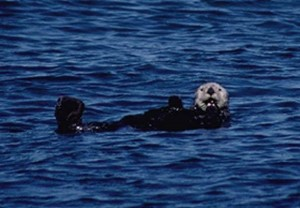



data/seacreatures/Starfish/26023545144_7e173d3dde_o.jpg
data/seacreatures/Puffers/26023545144_7e173d3dde_o.jpg


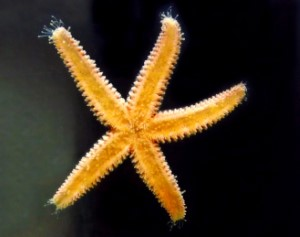



data/seacreatures/Seal/8422791314_9455cb3bd8_o.jpg
data/seacreatures/Seal/8624814281_e83ff803f5_o.jpg


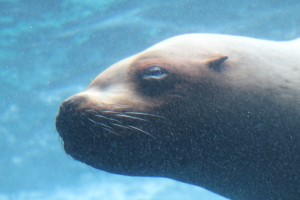



data/seacreatures/Seal/12539893564_0748e567c0_o.jpg
data/seacreatures/Seal/8189769731_f2d9d8372b_o.jpg


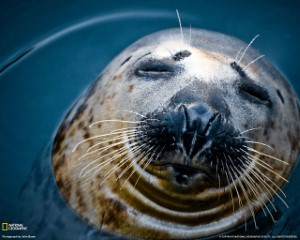



data/seacreatures/Puffers/97193335_f49f1d8e78_b.jpg
data/seacreatures/Sharks/97193335_f49f1d8e78_b.jpg


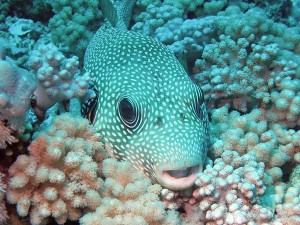



data/seacreatures/Puffers/32270540500_b4a42f901c_o.jpg
data/seacreatures/Sea Rays/32270540500_b4a42f901c_o.jpg


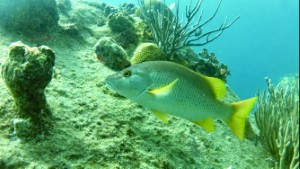



data/seacreatures/Puffers/36323330391_81b261ca76_o.jpg
data/seacreatures/Shrimp/36323330391_81b261ca76_o.jpg


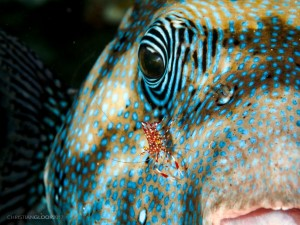



data/seacreatures/Sea Rays/24464089355_764a51a12a_b.jpg
data/seacreatures/Sharks/24464089355_764a51a12a_b.jpg


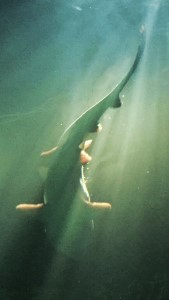



data/seacreatures/Octopus/26178694450_ca915b6215_o.jpg
data/seacreatures/Octopus/21387927708_07841db656_o.jpg


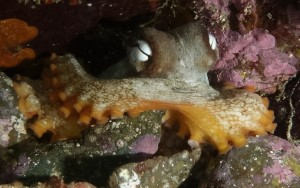

In [6]:
for dupe_group in dupes:
    for f in dupe_group:
        print(f)
    im = Image.open(dupe_group[0])
    display(im)
    print('\n')

Removal of duplicate images will be handled in separate script (remove_duplicates.py)

Additionally, add padding to images so they are square. This prevents distortion of the image when resizing.

## Images after removing duplicates

In [159]:
cleaned_data_dir = 'cleaned_padded_data'

In [160]:
total_images = 0
cat_counts = {}

for dirpath, dirnames, filenames in os.walk(cleaned_data_dir):
    if len(dirnames) == 0:
        total_images += len(filenames)
        cat_counts[os.path.basename(dirpath)] = len(filenames)

print(f"{total_images=}")
print(f"Total categories: {len(cat_counts.keys())}")
print(f"Images per category: {cat_counts}")

total_images=13635
Total categories: 23
Images per category: {'Seahorse': 477, 'Sea Urchins': 576, 'Clams': 494, 'Turtle_Tortoise': 1903, 'Dolphin': 771, 'Jelly Fish': 845, 'Penguin': 482, 'Squid': 479, 'Crabs': 499, 'Lobster': 498, 'Whale': 539, 'Eel': 494, 'Otter': 498, 'Starfish': 499, 'Seal': 412, 'Puffers': 525, 'Sea Rays': 514, 'Sharks': 586, 'Shrimp': 486, 'Octopus': 560, 'Fish': 498, 'Corals': 500, 'Nudibranchs': 500}


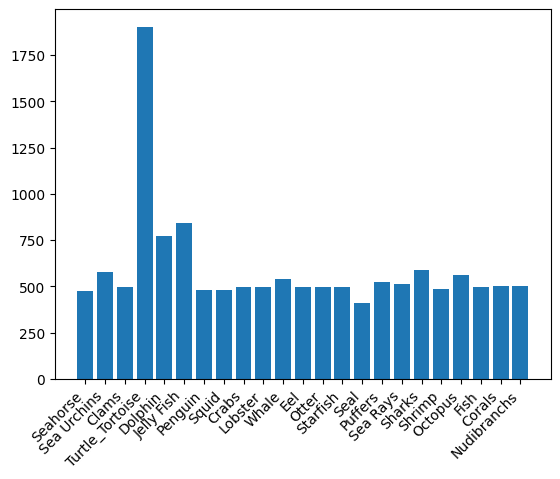

In [161]:
keys = list(cat_counts.keys())
vals = list(cat_counts.values())
plt.bar(range(len(cat_counts)), vals, tick_label=keys)
plt.xticks(rotation=45, ha='right')
plt.show()

The 3 categories with the most number of samples are "Turtle_Tortoise", "Dolphin", and "Jelly Fish". I'm going to opt to sample 500 images from each of those categories just so we are in the ballpark of the other categories.

Turtle_Tortoise is a particularly interesting (weird) set. Typically, tortoises spend their entire lives on land, so I'm not sure why there are tortoises in this dataset to begin with. The right thing to do would be to remove all tortoise images, but I don't think I have the time to do that.

# Data preparation

## Prepare datasets

In [162]:
def canonicalize_category(cat_name):
    return cat_name.lower().replace(' ', '_')

In [163]:
seed = 29

In [164]:
columns = ["filename", "class"]

# Only train a model on a subet of the images: creatures that actually live in the ocean.
# i.e. drop Turtle_Tortoise, Otter, Seal, and Penguin. Also, drop Puffers since they're technically fish.
selected_categories = [c for c in cat_counts.keys() if c not in ['Turtle_Tortoise', 'Otter', 'Seal', 'Penguin', 'Puffers']]

# Only take the first 500 of these, since they have a lot more samples than other classes
outlier_cats = ["dolphin", "jelly_fish", "turtle_tortoise"]

full_data = []

for cat in cat_counts.keys():
    if cat not in selected_categories:
        continue
    canon_cat = canonicalize_category(cat)
    listed_files_ds = tf.data.Dataset.list_files(f"{cleaned_data_dir}/seacreatures/{cat}/*")
    ds_size = int(listed_files_ds.cardinality())
    # do a full shuffle, we don't have that many elements in each dataset
    full_ds = listed_files_ds.shuffle(ds_size, seed=seed)
    if canon_cat in outlier_cats:
        ds = full_ds.take(500)
    else:
        ds = full_ds
    
    full_data.extend([(f.numpy().decode("utf-8"), canon_cat) for f in ds])

full_df = pd.DataFrame(full_data, columns=columns).sample(frac=1)
full_df.describe()

filename   class
count                                                9199    9199
unique                                               9199      18
top     cleaned_padded_data/seacreatures/Shrimp/311105...  sharks
freq                                                    1     586

In [165]:
full_df['class'].unique()

array(['shrimp', 'corals', 'crabs', 'eel', 'nudibranchs', 'fish',
       'sea_urchins', 'jelly_fish', 'whale', 'clams', 'sea_rays',
       'seahorse', 'lobster', 'starfish', 'squid', 'sharks', 'dolphin',
       'octopus'], dtype=object)

In [166]:
train_df, test_df = train_test_split(full_df, test_size=0.2, random_state=seed)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [167]:
len(train_df), len(test_df)

(7359, 1840)

In [168]:
train_df.head()

filename     class
0  cleaned_padded_data/seacreatures/Lobster/68376...   lobster
1  cleaned_padded_data/seacreatures/Octopus/31768...   octopus
2  cleaned_padded_data/seacreatures/Clams/3347534...     clams
3  cleaned_padded_data/seacreatures/Seahorse/5302...  seahorse
4  cleaned_padded_data/seacreatures/Sea Rays/3640...  sea_rays

In [169]:
test_df.head()

filename       class
0  cleaned_padded_data/seacreatures/Dolphin/Dolph...     dolphin
1  cleaned_padded_data/seacreatures/Sharks/542746...      sharks
2  cleaned_padded_data/seacreatures/Whale/8407934...       whale
3  cleaned_padded_data/seacreatures/Sharks/Sharks...      sharks
4  cleaned_padded_data/seacreatures/Jelly Fish/62...  jelly_fish

In [170]:
# find whether there are common rows in train and test df
intersection = pd.merge(train_df, test_df, how='inner', on=['filename'])
intersection

Empty DataFrame
Columns: [filename, class_x, class_y]
Index: []

In [171]:
any(train_df['filename'].duplicated()), any(test_df['filename'].duplicated())

(False, False)

In [172]:
# distribution classes in train_df
train_df.groupby(by='class').size()

class
clams          394
corals         401
crabs          399
dolphin        400
eel            393
fish           399
jelly_fish     394
lobster        390
nudibranchs    407
octopus        435
sea_rays       414
sea_urchins    450
seahorse       392
sharks         472
shrimp         394
squid          390
starfish       409
whale          426
dtype: int64

In [173]:
# distribution classes in test_df
test_df.groupby(by='class').size()

class
clams          100
corals          99
crabs          100
dolphin        100
eel            101
fish            99
jelly_fish     106
lobster        108
nudibranchs     93
octopus        125
sea_rays       100
sea_urchins    126
seahorse        85
sharks         114
shrimp          92
squid           89
starfish        90
whale          113
dtype: int64

## Image data generators (simple)

In [174]:
cwd = os.getcwd()

In [175]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
)

test_gen = ImageDataGenerator(rescale=1./255)

train_ds = train_gen.flow_from_dataframe(
    train_df,
    directory=cwd,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
)

test_ds = test_gen.flow_from_dataframe(
    test_df,
    directory=cwd,
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

Found 7359 validated image filenames belonging to 18 classes.
Found 1840 validated image filenames belonging to 18 classes.


In [189]:
num_classes = len(train_ds.class_indices)
num_classes

18

# Train model

## Basic CNN

In [186]:
def make_model_cnn(input_shape, conv_filters, conv_kernel_size, pool_size, num_classes, learning_rate=0.002):
    model = keras.models.Sequential()

    model.add(
        keras.layers.Conv2D(
            conv_filters,
            conv_kernel_size,
            input_shape=input_shape,
            activation='relu',
        )
    )
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))

    model.add(
        keras.layers.Conv2D(
            conv_filters * 2,
            conv_kernel_size,
            activation='relu',
        )
    )
    model.add(keras.layers.MaxPooling2D(pool_size=pool_size))
    
    model.add(keras.layers.Flatten())
    
    model.add(keras.layers.Dense(conv_filters * 4, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [190]:
def plot_history(history, model_name):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(f'Training and Validation Accuracy ({model_name})')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(f'Training and Validation Loss ({model_name})')
    plt.legend()

    plt.show()

In [191]:
model_simple = make_simple_model((150, 150, 3), 32, (3, 3), (2, 2), num_classes, learning_rate=0.002)
model_simple.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 74, 74, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (None, 36, 36, 64)        0         
 ng2D)                                                           
                                                                 
 flatten_5 (Flatten)         (None, 82944)             0         
                                                                 
 dense_23 (Dense)            (None, 64)              

In [192]:
history_simple1 = model_simple.fit(train_ds, epochs=10, validation_data=test_ds)

Epoch 1/10
230/230 [==============================] - 112s 482ms/step - loss: 2.6336 - accuracy: 0.1563 - val_loss: 2.3743 - val_accuracy: 0.2120
Epoch 2/10
230/230 [==============================] - 118s 512ms/step - loss: 2.3780 - accuracy: 0.2273 - val_loss: 2.2771 - val_accuracy: 0.2478
Epoch 3/10
230/230 [==============================] - 114s 496ms/step - loss: 2.3135 - accuracy: 0.2502 - val_loss: 2.2171 - val_accuracy: 0.2745
Epoch 4/10
230/230 [==============================] - 118s 514ms/step - loss: 2.2758 - accuracy: 0.2699 - val_loss: 2.2139 - val_accuracy: 0.2668
Epoch 5/10
230/230 [==============================] - 120s 520ms/step - loss: 2.2357 - accuracy: 0.2835 - val_loss: 2.1147 - val_accuracy: 0.3000
Epoch 6/10
172/230 [=====================>........] - ETA: 27s - loss: 2.2024 - accuracy: 0.2889

KeyboardInterrupt: 

In [ ]:
plot_history(history_simple1, 'model_simple')

The accuracy is mediocre. I will try using a pre-trained model as the base model, since the images have a lot of stuff going on and many of the sea creatures just blend in (e.g. lots of textures from sand, rocks, coral, seaweed, etc.)

Looking at FathomNet, it looks like their [models](https://github.com/fathomnet/models) were also trained on top of another model like YOLOv5 or ResNet50, so let's give it a shot.

## Image data generators (ResNet50)

In [ ]:
def make_model_resnet(input_shape, num_classes, learning_rate=0.001):
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )

    for layer in base_model.layers:
        layer.trainable = False

    model = keras.models.Sequential()
    model.add(base_model)

    model.add(keras.layers.GlobalAveragePooling2D())
    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [215]:
train_gen_resnet = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = ImageDataGenerator(rescale=1./255)

train_ds_resnet = train_gen_resnet.flow_from_dataframe(
    train_df,
    directory=cwd,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
)

test_ds_resnet = test_gen.flow_from_dataframe(
    test_df,
    directory=cwd,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 7359 validated image filenames belonging to 18 classes.
Found 1840 validated image filenames belonging to 18 classes.


In [216]:
model_resnet = make_model_resnet((150, 150, 3), num_classes, learning_rate=0.001)
model_resnet.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 3 (GlobalAveragePooling2D)                                      
                                                                 
 dense_37 (Dense)            (None, 128)               262272    
                                                                 
 dense_38 (Dense)            (None, 18)                2322      
                                                                 
Total params: 23852306 (90.99 MB)
Trainable params: 264594 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


In [ ]:
history_simple2 = model_resnet.fit(train_ds_resnet, epochs=10, validation_data=test_ds_resnet)

Epoch 1/10
230/230 [==============================] - 791s 3s/step - loss: 2.6626 - accuracy: 0.1459 - val_loss: 3.0543 - val_accuracy: 0.0761
Epoch 2/10
230/230 [==============================] - 719s 3s/step - loss: 2.4613 - accuracy: 0.2124 - val_loss: 3.3695 - val_accuracy: 0.0766
Epoch 3/10
230/230 [==============================] - 715s 3s/step - loss: 2.3749 - accuracy: 0.2412 - val_loss: 3.0127 - val_accuracy: 0.0978
Epoch 4/10
230/230 [==============================] - 726s 3s/step - loss: 2.3066 - accuracy: 0.2651 - val_loss: 3.0611 - val_accuracy: 0.0995
Epoch 5/10
230/230 [==============================] - 744s 3s/step - loss: 2.2707 - accuracy: 0.2704 - val_loss: 3.0285 - val_accuracy: 0.1207
Epoch 6/10
230/230 [==============================] - 715s 3s/step - loss: 2.2247 - accuracy: 0.2848 - val_loss: 3.0194 - val_accuracy: 0.1082
Epoch 7/10
230/230 [==============================] - 690s 3s/step - loss: 2.1827 - accuracy: 0.2972 - val_loss: 3.1788 - val_accuracy: 0.0967

In [ ]:
plot_history(history_simple2, 'model_simple_resnet')

In [ ]:
batch_size = 32
test_loss, test_acc = model_resnet.evaluate(test_ds_resnet, steps=test_ds_resnet.samples // batch_size)
print(f"Test Accuracy: {test_acc}")

## Add dropout

In [ ]:
def make_model_resnet_w_dropout(input_shape, num_classes, inner_dense_units=64, dropout_rate=0.50, learning_rate=0.001):
    base_model = keras.applications.resnet50.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
    )

    for layer in base_model.layers:
        layer.trainable = False

    model = keras.models.Sequential()
    model.add(base_model)

    model.add(keras.layers.GlobalAveragePooling2D())
    
    model.add(keras.layers.Dense(inner_dense_units, activation='relu'))
    model.add(keras.layers.Dropout(dropout_rate))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))

    optimizer = keras.optimizers.Adam(lr=learning_rate)
    
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [213]:
model_resnet_dropout = make_model_resnet_w_dropout((150, 150, 3), num_classes, inner_dense_units=128, dropout_rate=0.50, learning_rate=0.002)
model_resnet_dropout.summary()

Model: "sequential_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 5, 5, 2048)        23587712  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
 2 (GlobalAveragePooling2D)                                      
                                                                 
 dense_35 (Dense)            (None, 128)               262272    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_36 (Dense)            (None, 23)                2967      
                                                                 
Total params: 23852951 (90.99 MB)
Trainable params: 265239 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
________

In [214]:
history_simple3 = model_resnet_dropout.fit(train_ds_resnet, epochs=10, validation_data=test_ds_resnet)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node categorical_crossentropy/softmax_cross_entropy_with_logits defined at (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main

  File "<frozen runpy>", line 88, in _run_code

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/Users/carise/.pyenv/versions/3.11.7/lib/python3.11/asyncio/base_events.py", line 607, in run_forever

  File "/Users/carise/.pyenv/versions/3.11.7/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once

  File "/Users/carise/.pyenv/versions/3.11.7/lib/python3.11/asyncio/events.py", line 80, in _run

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3051, in run_cell

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3106, in _run_cell

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3311, in run_cell_async

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3493, in run_ast_nodes

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "/var/folders/nk/4y_m1jss3vv981dw0whbzz1w0000gp/T/ipykernel_11647/2247690664.py", line 1, in <module>

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1807, in fit

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/losses.py", line 143, in __call__

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/losses.py", line 270, in call

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/losses.py", line 2221, in categorical_crossentropy

  File "/Users/carise/.local/share/virtualenvs/ml-zoomcamp-capstone2-0mWT6mHI/lib/python3.11/site-packages/keras/src/backend.py", line 5579, in categorical_crossentropy

logits and labels must be broadcastable: logits_size=[32,23] labels_size=[32,18]
	 [[{{node categorical_crossentropy/softmax_cross_entropy_with_logits}}]] [Op:__inference_train_function_368398]

In [ ]:
plot_history(history_simple3, 'model_resnet_dropout')

In [ ]:
batch_size = 32
test_loss, test_acc = model_resnet_dropout.evaluate(test_ds_resnet, steps=test_ds_resnet.samples // batch_size)
print(f"Test Accuracy: {test_acc}, Test Loss: {test_loss}")

# Question 3

In [10]:
train_data_gen2 = ImageDataGenerator(rescale=1./255)
train_gen2 = train_data_gen2.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

test_data_gen2 = ImageDataGenerator(rescale=1./255)
test_gen2 = test_data_gen2.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

model2 = make_model((150, 150, 3), 32, (3, 3), (2, 2), learning_rate=0.002, momentum=0.8)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.


In [11]:
hist2 = model2.fit(
    train_gen2,
    epochs=10,
    validation_data=test_gen2
)

Epoch 1/10
184/184 [==============================] - 10s 50ms/step - loss: 0.6954 - accuracy: 0.5287 - val_loss: 0.6777 - val_accuracy: 0.5850
Epoch 2/10
184/184 [==============================] - 9s 48ms/step - loss: 0.6772 - accuracy: 0.5627 - val_loss: 0.6439 - val_accuracy: 0.6187
Epoch 3/10
184/184 [==============================] - 9s 48ms/step - loss: 0.6525 - accuracy: 0.6097 - val_loss: 0.6217 - val_accuracy: 0.6242
Epoch 4/10
184/184 [==============================] - 9s 48ms/step - loss: 0.6136 - accuracy: 0.6614 - val_loss: 0.5779 - val_accuracy: 0.7059
Epoch 5/10
184/184 [==============================] - 9s 48ms/step - loss: 0.5666 - accuracy: 0.7147 - val_loss: 0.5567 - val_accuracy: 0.7048
Epoch 6/10
184/184 [==============================] - 9s 49ms/step - loss: 0.5403 - accuracy: 0.7359 - val_loss: 0.5362 - val_accuracy: 0.7309
Epoch 7/10
184/184 [==============================] - 8s 45ms/step - loss: 0.5126 - accuracy: 0.7593 - val_loss: 0.5369 - val_accuracy: 0.729

In [12]:
hist2.history

{'loss': [0.6954396963119507,
  0.6772051453590393,
  0.6524572968482971,
  0.6135765910148621,
  0.5666470527648926,
  0.5403436422348022,
  0.5126460194587708,
  0.4897094964981079,
  0.4690507650375366,
  0.4563712775707245],
 'accuracy': [0.5286918878555298,
  0.5626869797706604,
  0.6097362041473389,
  0.6614087820053101,
  0.7147130966186523,
  0.7359260320663452,
  0.7593146562576294,
  0.7764481902122498,
  0.7946695685386658,
  0.7973891496658325],
 'val_loss': [0.6776949763298035,
  0.6439133882522583,
  0.6217292547225952,
  0.5778939723968506,
  0.5567148923873901,
  0.5362234711647034,
  0.5368881225585938,
  0.5212743282318115,
  0.5606775283813477,
  0.5355856418609619],
 'val_accuracy': [0.584967315196991,
  0.6187363862991333,
  0.6241829991340637,
  0.7058823704719543,
  0.7047930359840393,
  0.7309368252754211,
  0.7298474907875061,
  0.7516340017318726,
  0.6971677541732788,
  0.7342047691345215]}

In [13]:
np.median(hist2.history['accuracy'])

0.7253195643424988

# Question 4

In [14]:
np.mean(hist2.history['loss']), np.std(hist2.history['loss'])

(0.5673446983098984, 0.08341744413947431)

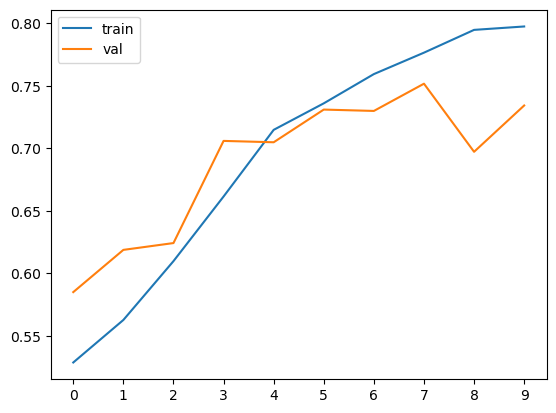

In [15]:
plt.plot(hist2.history['accuracy'], label='train')
plt.plot(hist2.history['val_accuracy'], label='val')
plt.xticks(np.arange(10))
plt.legend()

In [16]:
train_data_gen3 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')
train_gen3 = train_data_gen3.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary',
)

test_data_gen3 = ImageDataGenerator(rescale=1./255)
test_gen3 = test_data_gen3.flow_from_directory(
    test_data_dir,
    target_size=(150, 150),
    batch_size=20,
    shuffle=True,
    class_mode='binary'
)

hist3 = model2.fit(
    train_gen3,
    epochs=10,
    validation_data=test_gen3
)

Found 3677 images belonging to 2 classes.
Found 918 images belonging to 2 classes.
Epoch 1/10
184/184 [==============================] - 25s 133ms/step - loss: 0.5119 - accuracy: 0.7604 - val_loss: 0.5013 - val_accuracy: 0.7789
Epoch 2/10
184/184 [==============================] - 25s 133ms/step - loss: 0.5011 - accuracy: 0.7699 - val_loss: 0.4874 - val_accuracy: 0.7702
Epoch 3/10
184/184 [==============================] - 24s 133ms/step - loss: 0.4902 - accuracy: 0.7786 - val_loss: 0.5084 - val_accuracy: 0.7462
Epoch 4/10
184/184 [==============================] - 25s 133ms/step - loss: 0.4762 - accuracy: 0.7803 - val_loss: 0.5389 - val_accuracy: 0.7473
Epoch 5/10
184/184 [==============================] - 24s 133ms/step - loss: 0.4822 - accuracy: 0.7784 - val_loss: 0.4654 - val_accuracy: 0.7843
Epoch 6/10
184/184 [==============================] - 24s 131ms/step - loss: 0.4699 - accuracy: 0.7865 - val_loss: 0.4674 - val_accuracy: 0.7908
Epoch 7/10
184/184 [===========================

In [17]:
hist3.history

{'loss': [0.5118579864501953,
  0.5010568499565125,
  0.4902306795120239,
  0.47622641921043396,
  0.48222821950912476,
  0.46985411643981934,
  0.46699419617652893,
  0.47024667263031006,
  0.4648488759994507,
  0.46608591079711914],
 'accuracy': [0.760402500629425,
  0.7699211239814758,
  0.7786238789558411,
  0.7802556157112122,
  0.778351902961731,
  0.7865107655525208,
  0.7856948375701904,
  0.781887412071228,
  0.7908621430397034,
  0.7862387895584106],
 'val_loss': [0.5013285875320435,
  0.4874446392059326,
  0.5083593130111694,
  0.5389356017112732,
  0.4653896391391754,
  0.4673716425895691,
  0.4739697575569153,
  0.4484111964702606,
  0.46149125695228577,
  0.43861812353134155],
 'val_accuracy': [0.7788671255111694,
  0.7701525092124939,
  0.7461873888969421,
  0.7472766637802124,
  0.7843137383460999,
  0.7908496856689453,
  0.7810457348823547,
  0.7897603511810303,
  0.7788671255111694,
  0.8039215803146362]}

# Question 5

In [18]:
np.mean(hist3.history['val_loss'])

0.47913197576999667

# Question 6

In [19]:
np.mean(hist3.history['val_accuracy'][5:])

0.7888888955116272